# Big Data Project: Flight Delay Prediction Using Spark Streaming & Kafka

## (1) Data Loading

Flight Dataset: https://www.kaggle.com/datasets/patrickzel/flight-delay-and-cancellation-dataset-2019-2023?select=flights_sample_3m.csv

In [1]:
# Setup Spark path
import findspark

findspark.init()

In [2]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("FlightDataAnalysis").getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/23 04:55:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Load and parse the data file, converting it to a DataFrame.
df = spark.read.csv("flight_data.csv", header=True, inferSchema=True)

# Show 1st 5 rows of dataframe
df.show(5)


25/03/23 04:57:17 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

+----------+--------------------+--------------------+------------+--------+---------+------+-------------------+----+--------------------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+
|   FL_DATE|             AIRLINE|         AIRLINE_DOT|AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|        ORIGIN_CITY|DEST|           DEST_CITY|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|DELAY_DUE_CARRIER|DELAY_DUE_WEATHER|DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|
+----------+--------------------+--------------------+------------+--------+---------+------+-------------------+----+--------------------+------------+--------

In [6]:
# Show schema of dataframe
df.printSchema()


root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)

In [25]:
from pyspark.sql.types import IntegerType, DoubleType, FloatType

In [27]:
# Get a list of columns with numeric types
numericColumns = [col for col, dtype in df.dtypes if isinstance(df.schema[col].dataType, (IntegerType, DoubleType, FloatType))]

print(numericColumns)

['DOT_CODE', 'FL_NUMBER', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']


In [28]:
import pyspark.sql.functions as F
import pandas as pd

In [29]:
# Get the basic statistics of the DataFrame for the numeric columns
df_stats = df.select([F.round(F.col(c), 2).alias(c) for c in numericColumns]).describe()

# Convert the result to a Pandas DataFrame
df_stats_pd = df_stats.toPandas()

# Round the numeric values (except for the 'summary' row)
df_stats_pd.iloc[1:, 1:] = df_stats_pd.iloc[1:, 1:].apply(pd.to_numeric, errors='coerce').round(2)

# Set the 'summary' features as the index
df_stats_pd.set_index('summary', inplace=True)

print(df_stats_pd)


         DOT_CODE FL_NUMBER CRS_DEP_TIME DEP_TIME DEP_DELAY TAXI_OUT  \
summary                                                                
count      266375    266375       266374   259382    259379   259288   
mean     19978.02   2515.62      1327.41  1330.33     10.21    16.65   
stddev     377.07    1746.0       486.15    499.7     49.41      9.2   
min       19393.0       1.0          1.0      1.0     -68.0      1.0   
max       20452.0    8814.0       2359.0   2400.0    1732.0    172.0   

        WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME  ... DIVERTED  \
summary                                            ...            
count       259288    259189  259189       266374  ...   266374   
mean       1352.83   1462.67    7.68      1491.06  ...      0.0   
stddev      501.31    527.75    6.25       511.98  ...     0.05   
min            1.0       1.0     1.0          1.0  ...      0.0   
max         2400.0    2400.0   222.0       2400.0  ...      1.0   

        CRS_ELAPSED_TIME 

#### Note: tried to use .describe().show() on original df and couldn't get any information out of it (messy)

## (2) Cleaning

In [30]:
# Find # of null values for each column in df
[df.filter(df[col].isNull()).count() for col in df.columns]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 6993,
 6996,
 7087,
 7087,
 7186,
 7186,
 1,
 7186,
 7699,
 1,
 259259,
 1,
 3,
 7699,
 7699,
 1,
 218893,
 218893,
 218893,
 218893,
 218893]

In [31]:
# Dropping crucial data for delays and then filling null delay causes with 0
df = df.dropna(subset=["ARR_DELAY", "DEP_DELAY"])
df = df.fillna({'DELAY_DUE_CARRIER': 0, 'DELAY_DUE_WEATHER': 0, 'DELAY_DUE_NAS': 0, 'DELAY_DUE_SECURITY': 0, 'DELAY_DUE_LATE_AIRCRAFT': 0})

In [32]:
# Convert flight date to yyyy-MM-dd format
df = df.withColumn("FL_DATE", F.to_date(F.col("FL_DATE"), "yyyy-MM-dd"))

# Create new column to indicate severe delays
# can switch severity if needed
df = df.withColumn("SEVERE_DELAY", F.when(F.col("ARR_DELAY") >= 60, 1).otherwise(0))

df.select("FL_DATE", "AIRLINE", "ARR_DELAY", "SEVERE_DELAY").show(5)


+----------+--------------------+---------+------------+
|   FL_DATE|             AIRLINE|ARR_DELAY|SEVERE_DELAY|
+----------+--------------------+---------+------------+
|2019-01-09|United Air Lines ...|    -14.0|           0|
|2022-11-19|Delta Air Lines Inc.|     -5.0|           0|
|2022-07-22|United Air Lines ...|      0.0|           0|
|2023-03-06|Delta Air Lines Inc.|     24.0|           0|
|2020-02-23|    Spirit Air Lines|     -1.0|           0|
+----------+--------------------+---------+------------+
only showing top 5 rows



In [33]:
# Find # of null values for each column in df (show changes)
[df.filter(df[col].isNull()).count() for col in df.columns]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 258676,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [34]:
# Drop Cancellation Code Column (which has a bunch of null values)
df = df.drop('CANCELLATION_CODE')

In [35]:
# Find # of null values for each column in df (show changes)
[df.filter(df[col].isNull()).count() for col in df.columns]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [46]:
# Show columns after dropping Cancellation Code column
df.columns

['FL_DATE',
 'AIRLINE',
 'AIRLINE_CODE',
 'ORIGIN',
 'ORIGIN_CITY',
 'DEST',
 'DEST_CITY',
 'CRS_DEP_TIME',
 'DEP_TIME',
 'DEP_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'WHEELS_ON',
 'TAXI_IN',
 'CRS_ARR_TIME',
 'ARR_TIME',
 'ARR_DELAY',
 'CANCELLED',
 'DIVERTED',
 'CRS_ELAPSED_TIME',
 'ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'DELAY_DUE_CARRIER',
 'DELAY_DUE_WEATHER',
 'DELAY_DUE_NAS',
 'DELAY_DUE_SECURITY',
 'DELAY_DUE_LATE_AIRCRAFT',
 'SEVERE_DELAY']

## (3) Transformation: Encoding and Scaling

In [37]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler

In [38]:
df = df.drop(*['AIRLINE_DOT', 'DOT_CODE', 'FL_NUMBER'])

In [39]:
categorical_cols = ["AIRLINE", "ORIGIN", "DEST"]

indexers = [StringIndexer(inputCol = col, outputCol = col + "Index") for col in categorical_cols]

In [40]:
encoders = [OneHotEncoder(inputCol = col + "Index", outputCol=col + "OneHot") for col in categorical_cols]

In [41]:
numeric_cols = ["DEP_DELAY", "TAXI_OUT", "TAXI_IN", "ARR_DELAY", "DISTANCE",
                "DELAY_DUE_CARRIER", "DELAY_DUE_WEATHER", "DELAY_DUE_NAS",
                "DELAY_DUE_SECURITY", "DELAY_DUE_LATE_AIRCRAFT"]


assembler = VectorAssembler(inputCols = numeric_cols, outputCol="features")

scaler = MinMaxScaler(inputCol = "features", outputCol = "scaled_features")

In [42]:
final_assembler = VectorAssembler(
    inputCols = ["AIRLINEOneHot", "ORIGINOneHot", "DESTOneHot", "scaled_features"],
    outputCol = "final_features"
)

In [43]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = indexers + encoders + [assembler, scaler, final_assembler])

In [44]:
processed_df = pipeline.fit(df).transform(df)

In [45]:
processed_df.select("final_features", "SEVERE_DELAY").show(5)

+--------------------+------------+
|      final_features|SEVERE_DELAY|
+--------------------+------------+
|(779,[4,39,412,76...|           0|
|(779,[1,30,403,76...|           0|
|(779,[4,20,408,76...|           0|
|(779,[1,30,409,76...|           0|
|(779,[11,27,396,7...|           0|
+--------------------+------------+
only showing top 5 rows



## (4) Visualization

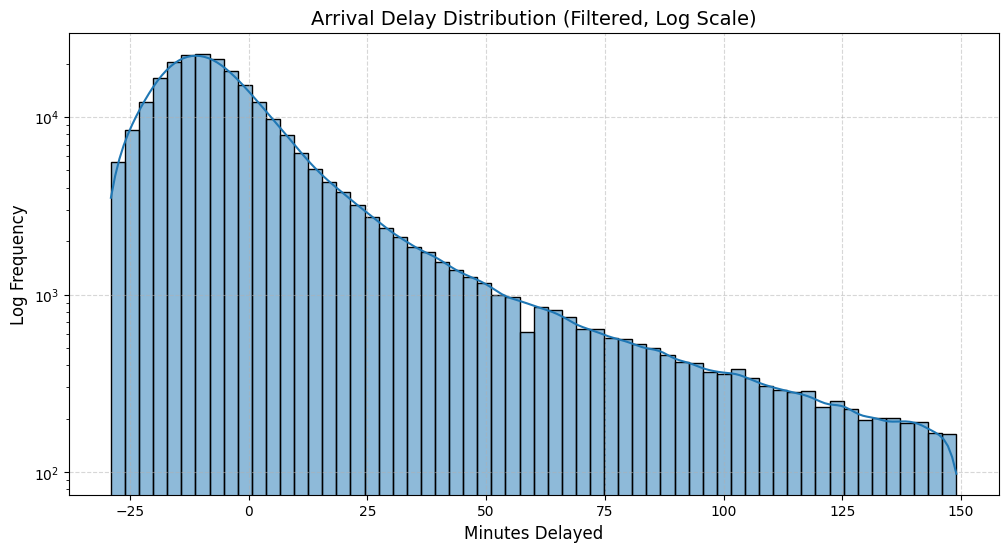

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas
pd_df = df.select("ARR_DELAY").toPandas()

pd_df_filtered = pd_df[(pd_df["ARR_DELAY"] > -30) & (pd_df["ARR_DELAY"] < 150)]

plt.figure(figsize=(12, 6))
sns.histplot(pd_df_filtered["ARR_DELAY"].dropna(), bins=60, kde=True)

plt.yscale("log")

plt.title("Arrival Delay Distribution (Filtered, Log Scale)", fontsize=14)
plt.xlabel("Minutes Delayed", fontsize=12)
plt.ylabel("Log Frequency", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


In [47]:
airline_delays = df.groupBy("AIRLINE").agg(F.avg("ARR_DELAY").alias("AvgArrDelay")).toPandas()

airline_delays = airline_delays.sort_values("AvgArrDelay", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x="AIRLINE", y="AvgArrDelay", data=airline_delays)
plt.xticks(rotation=90)
plt.title("Average Arrival Delay by Airline")
plt.xlabel("Airline")
plt.ylabel("Avg Delay (minutes)")
plt.show()


NameError: name 'plt' is not defined

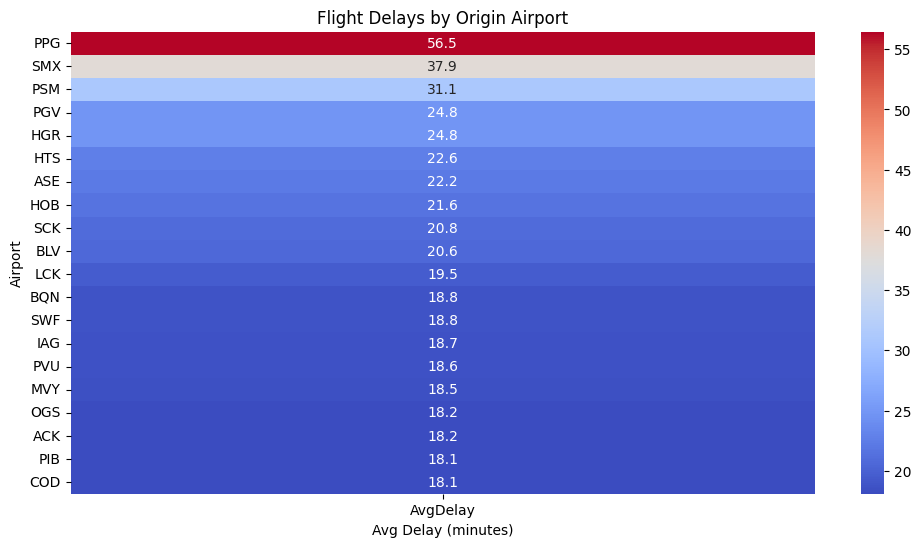

In [28]:
airport_delays = df.groupBy("ORIGIN").agg(F.avg("ARR_DELAY").alias("AvgDelay")).toPandas()
airport_delays = airport_delays.sort_values("AvgDelay", ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.heatmap(airport_delays.set_index("ORIGIN"), cmap="coolwarm", annot=True, fmt=".1f")
plt.title("Flight Delays by Origin Airport")
plt.xlabel("Avg Delay (minutes)")
plt.ylabel("Airport")
plt.show()


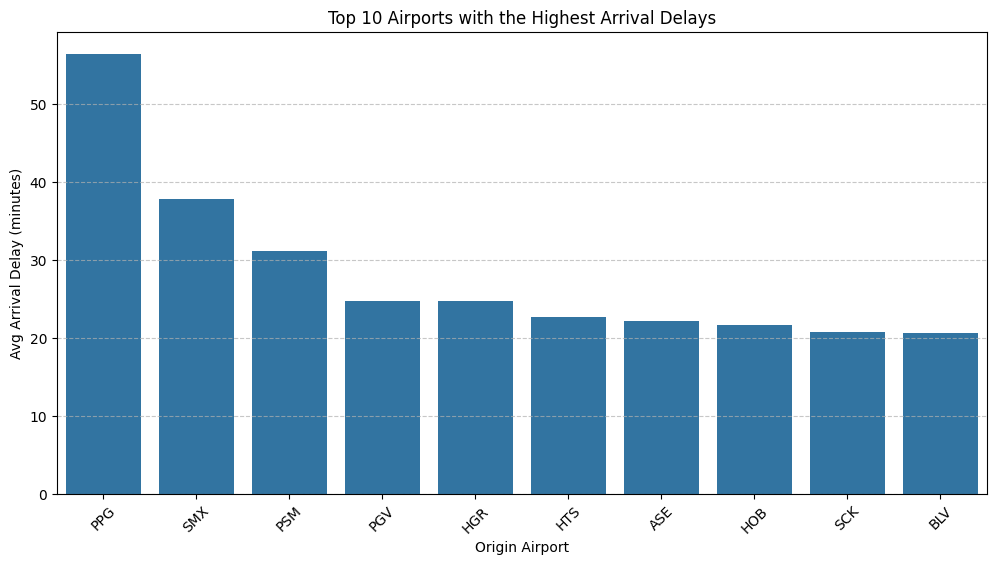

In [31]:
airport_delays = df.groupBy("ORIGIN").agg(F.avg("ARR_DELAY").alias("AvgDelay")).toPandas()
airport_delays_top10 = airport_delays.sort_values("AvgDelay", ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x="ORIGIN", y="AvgDelay", data=airport_delays_top10)

plt.xticks(rotation=45)
plt.title("Top 10 Airports with the Highest Arrival Delays")
plt.xlabel("Origin Airport")
plt.ylabel("Avg Arrival Delay (minutes)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()
